In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.cluster import KMeans


In [21]:
df = pd.read_csv('./data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [22]:
msv = 2151264665
col = msv%12 + 1 

In [23]:
data = df[[str(col)]]
data

,6
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


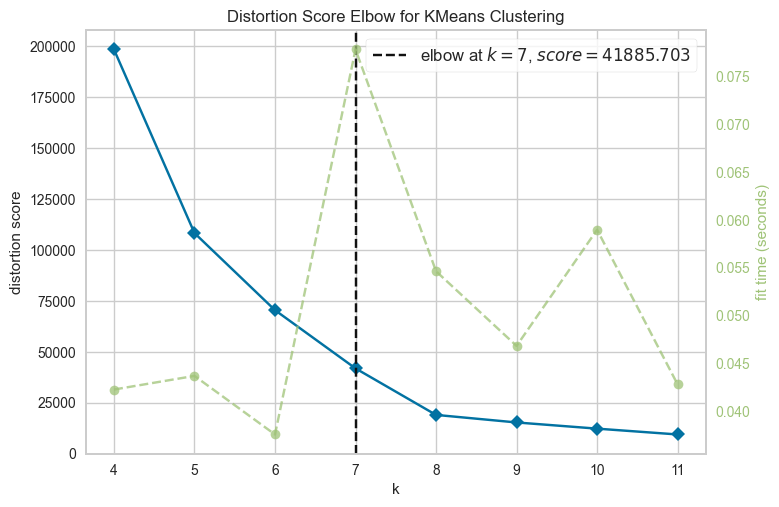

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

# Thực hiện các model

* BayesianGaussianMixture

In [25]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
bgm_preds = BGM.fit_predict(data)

* Gaussian

In [26]:
GMM = GaussianMixture(n_components=8)
# fit model and predict clusters
gmm_preds = GMM.fit_predict(data)

* Kmeans

In [27]:
Kmeans = KMeans(n_clusters=8) # Số clusters có thể điều chỉnh
# fit model and predict clusters
Kmeans.fit(data.values.reshape(-1, 1))
kmeans_labels = Kmeans.predict(data.values.reshape(-1, 1))


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Trainning

* BGM


In [28]:
pp1=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp1 # creating new dataframe columns of probabilites 
df_new['preds']=bgm_preds
df_new['predict_proba']=np.max(pp1,axis=1)
df_new['predict']=np.argmax(pp1,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [29]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.41407e-06
[400]	valid_0's multi_logloss: 6.41407e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.26776e-06
[400]	valid_0's multi_logloss: 6.26776e-06
[200]	valid_0's multi_logloss: 6.84467e-06
[400]	valid_0's multi_logloss: 6.84467e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06


In [30]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

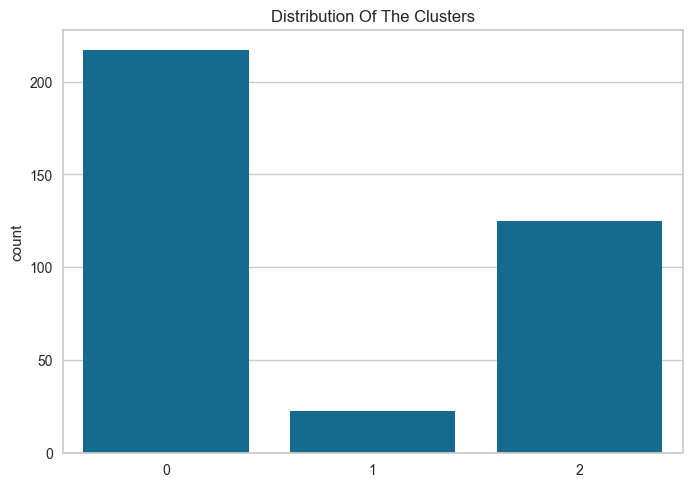

In [31]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

* GMM


In [32]:
pp2=GMM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp2 # creating new dataframe columns of probabilites 
df_new['preds']=gmm_preds
df_new['predict_proba']=np.max(pp2,axis=1)
df_new['predict']=np.argmax(pp2,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [33]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 4.78735e-05
[400]	valid_0's multi_logloss: 4.76564e-05
[600]	valid_0's multi_logloss: 4.76163e-05
[800]	valid_0's multi_logloss: 4.75487e-05
[1000]	valid_0's multi_logloss: 4.74979e-05
[1200]	valid_0's multi_logloss: 4.74585e-05
[1400]	valid_0's multi_logloss: 4.74269e-05
[1600]	valid_0's multi_logloss: 4.74012e-05
[1800]	valid_0's multi_logloss: 4.73797e-05
[2000]	valid_0's multi_logloss: 4.73616e-05
[2200]	valid_0's multi_logloss: 4.73461e-05
[2400]	valid_0's multi_logloss: 4.73327e-05
[2600]	valid_0's multi_logloss: 4.7321e-05
[2800]	valid_0's multi_logloss: 4.73106e-05
[3000]	valid_0's multi_logloss: 4.73014e-05
[3200]	valid_0's multi_logloss: 4.72932e-05
[3400]	valid_0's multi_logloss: 4.72859e-05
[3600]	valid_0's multi_logloss: 4.72792e-05
[3800]	valid_0's multi_logloss: 4.72731e-05
[4000]	valid_0's multi_logloss: 4.72676e-05
[4200]	valid_0's multi_logloss: 4.72625e-05
[4400]	valid_0's multi_logloss: 4.72579e-05
[4600]	valid_0's multi_logloss: 4.725

In [34]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

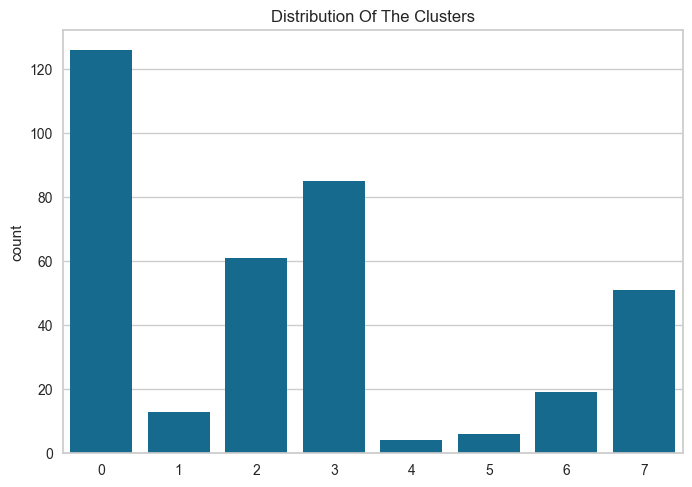

In [35]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

* Kmeans


In [36]:
pp3=Kmeans.predict(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp3 # creating new dataframe columns of probabilites 
df_new['preds']=bgm_preds
df_new['predict_proba']=np.max(pp3,axis=1)
df_new['predict']=np.argmax(pp3,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


ValueError: Columns must be same length as key

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()